# Classificação de imagens Sentinel 2 com Multilayer Perceptron

Remover warnings desnecessarios

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import numpy as np
import random as rd
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from scipy.signal import convolve2d
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [ ]:
pp = papiro_path = "./drive/MyDrive/ColabNotebooks/ClassImg" # no meu caso

# Work arround pra montar pastas "Shared with me"
# go to Google Drive, right click on the folder in question, and then click "Add shortcut to Drive".

os.listdir(pp)

['S2',
 'S2_cutted',
 'Prints',
 'S2_AOI_nuvens',
 'Classification_CNN_S2.ipynb',
 'S2_area6_cutted',
 'S2_area8_cutted',
 'S2_area9_cutted',
 'Classification_MLP_S2.ipynb',
 'Classification_MLP_CBERS4A.ipynb',
 'CBERS4A',
 'k_means.gtif',
 'Clustering_KMeans-S2.ipynb',
 'Classification_MLP_S2_P2.ipynb']

## Dataset

In [ ]:
f = os.path.join(pp,'S2_cutted','S2B_tile_20190401_20NQH_0_B04.tif')
ds = gdal.Open(f, gdal.GA_ReadOnly)
arr = ds.GetRasterBand(1).ReadAsArray()
# # Use var from already computed cell to get image size and type
bands = np.zeros((ds.RasterYSize,
                  ds.RasterXSize,
                  len(os.listdir(os.path.join(pp,'S2_cutted')))
                  ),
                  gdal_array.GDALTypeCodeToNumericTypeCode(ds.GetRasterBand(1).DataType))

# Resample bands with smaller shapes (B01= 232,231) (B02= 1393,1385)...
# Done in Preparo no FME

files = []
for i, b in enumerate(sorted(os.listdir(os.path.join(pp,'S2_cutted')))):
  print(b)
  f = os.path.join(pp,'S2_cutted',b)
  files.append(b)
  ds = gdal.Open(os.path.join(pp,'S2_cutted',b), gdal.GA_ReadOnly)
  band = ds.GetRasterBand(1).ReadAsArray()
  bands[:, :, i] = band

print('X shape:',bands.shape)

ds = gdal.Open(os.path.join(pp,'S2_AOI_nuvens','nuvens.tif'), gdal.GA_ReadOnly)
nuvens = ds.GetRasterBand(1).ReadAsArray()
print('Y shape:',nuvens.shape)


./drive/MyDrive/ColabNotebooks/ClassImg/S2_cutted/S2B_tile_20190401_20NQH_0_B04.tif
S2B_tile_20190401_20NQH_0_B01.tif
S2B_tile_20190401_20NQH_0_B02.tif
S2B_tile_20190401_20NQH_0_B03.tif
S2B_tile_20190401_20NQH_0_B04.tif
S2B_tile_20190401_20NQH_0_B05.tif
S2B_tile_20190401_20NQH_0_B06.tif
S2B_tile_20190401_20NQH_0_B07.tif
S2B_tile_20190401_20NQH_0_B08.tif
S2B_tile_20190401_20NQH_0_B09.tif
S2B_tile_20190401_20NQH_0_B11.tif
S2B_tile_20190401_20NQH_0_B12.tif
S2B_tile_20190401_20NQH_0_B8A.tif
X shape: (1385, 1393, 12)
Y shape: (1385, 1393)


## Normalizando os vetores de entrada

In [ ]:
scaler = MinMaxScaler()
scaler.fit(bands.reshape(-1,1)) # Compute min/max to be used for later scaling. See scaler.data_max_
X_Inputs = scaler.transform(bands.reshape(-1,1)) # Fit to data, then transform it.
X_Inputs = X_Inputs.reshape(bands.shape)
print(X_Inputs.shape)

(1385, 1393, 12)


In [ ]:
import pickle

# save the model to a file
with open('minmax_scaler_2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Split em treino e validação (teste é tudo)

In [ ]:
def my_split_v2(x,y):
  # Do not go random, just use last data to train model
  # Also do not use x_test because the hole imagem will be X_test
  x_val  = x[254:842,1000:-1,:]
  y_val  = y[254:842,1000:-1]
  print("x_val:",x_val.shape)
  x_train = x[700:1385,290:,:]
  y_train = y[700:1385,290:]
  print("x_train:",x_train.shape)
  return x_train, y_train, x_val, y_val

In [ ]:
x_train, y_train, x_val, y_val = my_split_v2(X_Inputs, nuvens)

x_val: (588, 392, 12)
x_train: (685, 1103, 12)


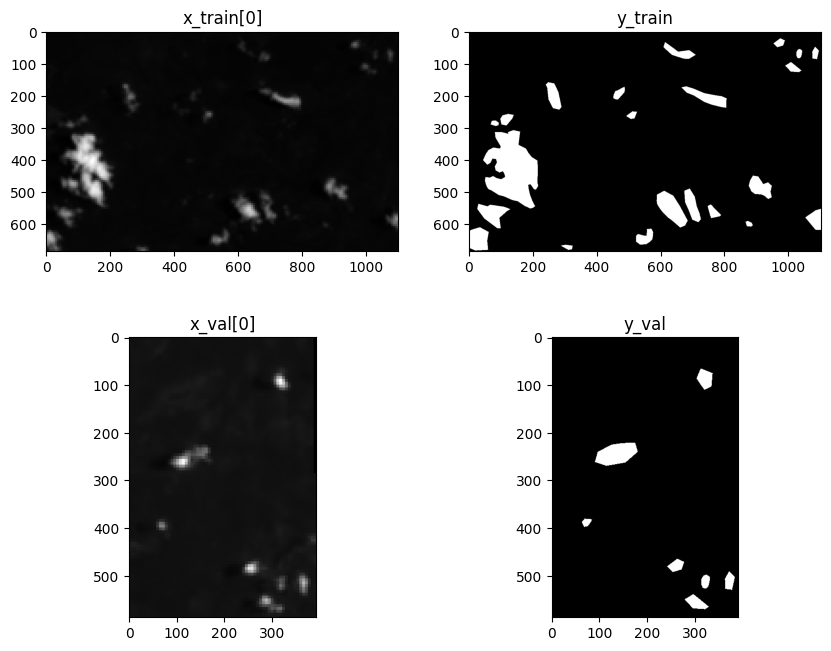

In [ ]:
# plot dataset sample and objective
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8))
ax1.set_title("x_train[0]")
ax1.imshow(x_train[:,:,0], cmap=plt.get_cmap("gray"))
ax2.set_title("y_train")
ax2.imshow(y_train, cmap=plt.get_cmap("gray"))

ax3.set_title("x_val[0]")
ax3.imshow(x_val[:,:,0], cmap=plt.get_cmap("gray"))
ax4.set_title("y_val")
ax4.imshow(y_val, cmap=plt.get_cmap("gray"))

plt.show()

In [ ]:
print(x_train.shape)
a = np.array([x_train[i,j,:] for i in range(x_train.shape[0]) for j in range(x_train.shape[1])])

y = np.array([y_train[i,j] for i in range(y_train.shape[0]) for j in range(y_train.shape[1])])
print(a.shape,y.shape)

(685, 1103, 12)
(755555, 12) (755555,)


## Model

In [ ]:
# Criando um modelo Sequential e adicionando as camadas
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(a.shape[1], )    ))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 64)                832       
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:

bs = 400
epochs = 3000000
UpdateCallback = tf.keras.callbacks.EarlyStopping(
                                                    monitor='loss',
                                                    min_delta=0.01,
                                                    patience=5,
                                                    verbose=0,
                                                    mode='auto',
                                                    baseline=None,
                                                    restore_best_weights=False,
                                                    start_from_epoch=0
                                                )

# This callback will stop the training when there is no improvement in the loss for three consecutive epochs. 47s --> 2,8s
# history = model.fit(a, y, epochs=epochs,batch_size=bs, verbose=2, callbacks=[], validation_data=(x_val, y_val))
history = model.fit(a, y, epochs=epochs,batch_size=bs, verbose=2, callbacks=[], validation_split=0.2)

Epoch 1/30
1512/1512 - 5s - loss: 0.1123 - accuracy: 0.9687 - val_loss: 0.1315 - val_accuracy: 0.9579 - 5s/epoch - 3ms/step
Epoch 2/30
1512/1512 - 6s - loss: 0.0610 - accuracy: 0.9777 - val_loss: 0.1176 - val_accuracy: 0.9580 - 6s/epoch - 4ms/step
Epoch 3/30
1512/1512 - 4s - loss: 0.0572 - accuracy: 0.9778 - val_loss: 0.1201 - val_accuracy: 0.9583 - 4s/epoch - 3ms/step
Epoch 4/30
1512/1512 - 4s - loss: 0.0560 - accuracy: 0.9779 - val_loss: 0.1256 - val_accuracy: 0.9561 - 4s/epoch - 3ms/step
Epoch 5/30
1512/1512 - 6s - loss: 0.0553 - accuracy: 0.9780 - val_loss: 0.1147 - val_accuracy: 0.9562 - 6s/epoch - 4ms/step
Epoch 6/30
1512/1512 - 6s - loss: 0.0549 - accuracy: 0.9782 - val_loss: 0.1182 - val_accuracy: 0.9577 - 6s/epoch - 4ms/step
Epoch 7/30
1512/1512 - 9s - loss: 0.0546 - accuracy: 0.9783 - val_loss: 0.1115 - val_accuracy: 0.9594 - 9s/epoch - 6ms/step
Epoch 8/30
1512/1512 - 4s - loss: 0.0543 - accuracy: 0.9783 - val_loss: 0.1182 - val_accuracy: 0.9575 - 4s/epoch - 3ms/step
Epoch 9/

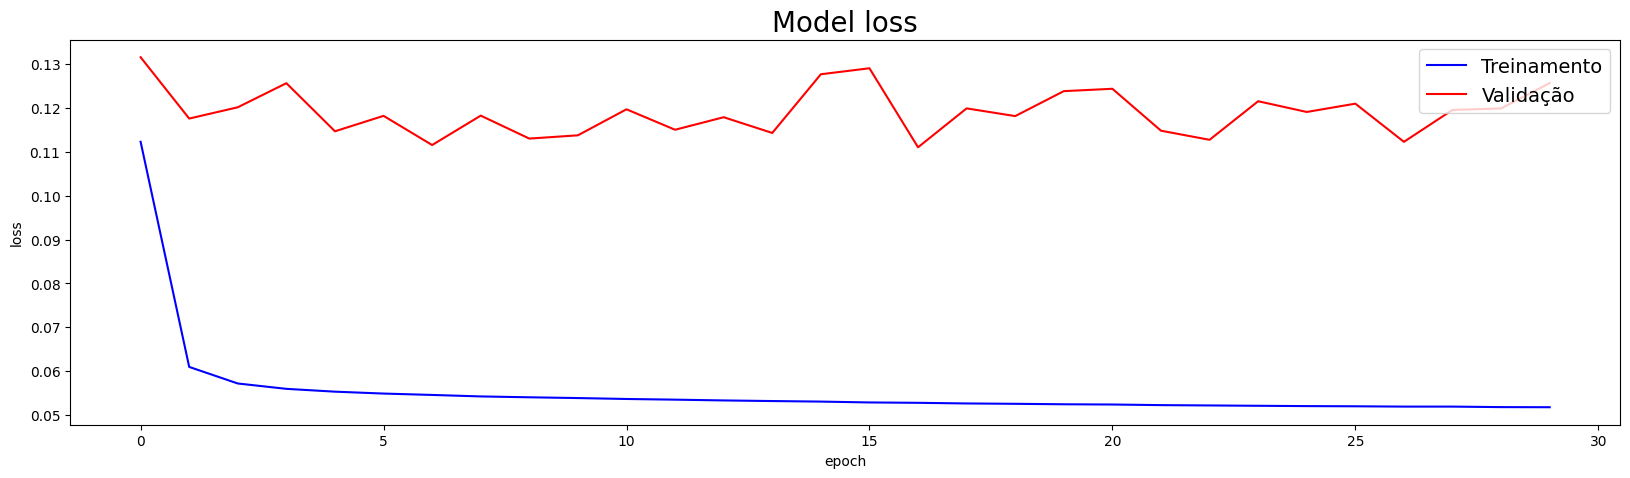

In [ ]:
# Plotando o historico do processo de treinamento
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
plt.title('Model loss', fontsize=20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Treinamento', 'Validação'], loc='upper right', fontsize=14)
plt.show()

In [ ]:
b = np.array([X_Inputs[i,j,:] for i in range(X_Inputs.shape[0]) for j in range(X_Inputs.shape[1])])
print(b.shape)
c = np.array([nuvens[i,j] for i in range(nuvens.shape[0]) for j in range(nuvens.shape[1])])
print(c.shape)

(1929305, 12)
(1929305,)


In [ ]:
score = model.evaluate(b, c, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.043453823775053024
Test accuracy: 0.9857549667358398


In [ ]:
fn = 'modelo_batch_%.5f_%.5f.keras' %(score[0],score[1])
print(fn)
model.save(os.path.join(pp,'S2_AOI_nuvens',fn))

modelo_batch_0.04345_0.98575.keras


In [ ]:
loaded_model = model
# loaded_model = tf.keras.models.load_model(os.path.join(pp,'S2_AOI_nuvens','modelo_0.06426_0.97806.keras'))

## Plot Y_pred

In [ ]:
Y_full_pred = loaded_model.predict(b)

60291/60291 [==============================] - 101s 2ms/step


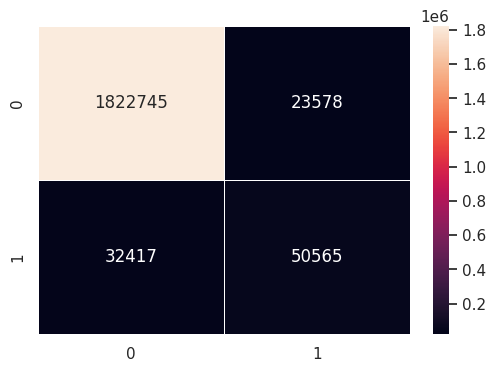

In [ ]:
sns.set_theme()
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(confusion_matrix(c, Y_full_pred), annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show()

In [ ]:
# aplicar o limiar na função sigma
d = np.array([0 if i<0.5 else 1 for i in Y_full_pred ])
print(d)

[0 0 0 ... 0 0 0]


In [ ]:
print(classification_report(c, d))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1846323
           1       0.87      0.79      0.83     82982

    accuracy                           0.99   1929305
   macro avg       0.93      0.89      0.91   1929305
weighted avg       0.99      0.99      0.99   1929305



## Regenerar a imagem predita

In [ ]:
d.reshape(nuvens.shape).shape

(1385, 1393)

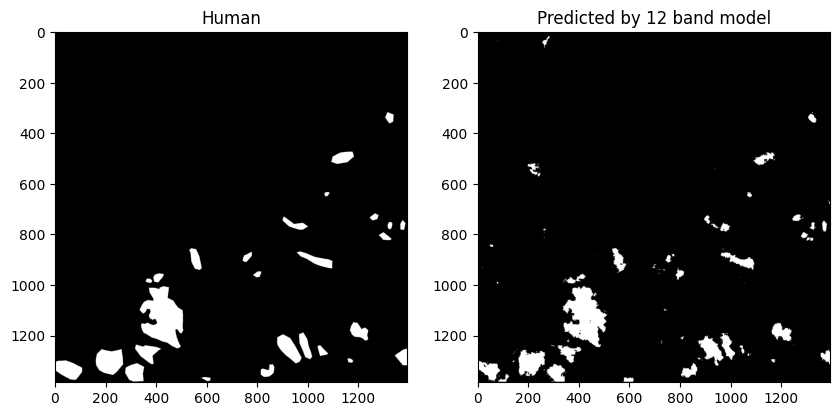

In [ ]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.set_title("Human")
ax1.imshow(nuvens,cmap=plt.get_cmap("gray"))
ax2.set_title("Predicted by 12 band model")
ax2.imshow(d.reshape(nuvens.shape),cmap=plt.get_cmap("gray"))
plt.show()